In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## Lookahead 测试
[alphadl/lookahead.pytorch: lookahead optimizer (Lookahead Optimizer: k steps forward, 1 step back) for pytorch](https://github.com/alphadl/lookahead.pytorch)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from lookahead import Lookahead
import matplotlib.pyplot as plt

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 100
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose(
    [transforms.Pad(4),
     transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32),
     transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../datasets/', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='../datasets/', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

model = torchvision.models.resnet50().to(device)

Files already downloaded and verified


In [4]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Train the model
loss_list = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    el = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        el+=loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    el = el/total_step
    loss_list.append(el)
    print("Epoch [{}/{}],  Loss: {:.4f}".format(epoch + 1, num_epochs, el))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Epoch [1/100],  Loss: 1.7150
Epoch [2/100],  Loss: 1.7589
Epoch [3/100],  Loss: 1.8171
Epoch [4/100],  Loss: 1.5906
Epoch [5/100],  Loss: 1.7529
Epoch [6/100],  Loss: 1.9229
Epoch [7/100],  Loss: 1.8371
Epoch [8/100],  Loss: 1.7239
Epoch [9/100],  Loss: 1.6148
Epoch [10/100],  Loss: 1.4915
Epoch [11/100],  Loss: 1.4264
Epoch [12/100],  Loss: 1.3454
Epoch [13/100],  Loss: 1.3781
Epoch [14/100],  Loss: 1.2017
Epoch [15/100],  Loss: 1.1643
Epoch [16/100],  Loss: 1.1569
Epoch [17/100],  Loss: 1.0009
Epoch [18/100],  Loss: 1.0166
Epoch [19/100],  Loss: 0.9720
Epoch [20/100],  Loss: 0.9361
Epoch [21/100],  Loss: 0.9013
Epoch [22/100],  Loss: 0.8898
Epoch [23/100],  Loss: 0.7803
Epoch [24/100],  Loss: 0.7275
Epoch [25/100],  Loss: 0.6999
Epoch [26/100],  Loss: 0.9785
Epoch [27/100],  Loss: 1.1904
Epoch [28/100],  Loss: 0.8149
Epoch [29/100],  Loss: 0.7038
Epoch [30/100],  Loss: 0.7070
Epoch [31/100],  Loss: 0.6398
Epoch [32/100],  Loss: 0.6036
Epoch [33/100],  Loss: 0.5851
Epoch [34/100],  Lo

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Accuracy of the model on the test images: 84.72 %


## 用 Lookahead

In [10]:
model = torchvision.models.resnet50().to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = Lookahead(optimizer, k=5, alpha=0.5) # 初始化Lookahead

In [11]:
# Train the model
loss_list1 = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    el = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        el+=loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    el/=total_step
    loss_list1.append(el)
    print("Epoch [{}/{}],  Loss: {:.4f}".format(epoch + 1, num_epochs,  el))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Epoch [1/100],  Loss: 1.9331
Epoch [2/100],  Loss: 1.5717
Epoch [3/100],  Loss: 1.4679
Epoch [4/100],  Loss: 1.3494
Epoch [5/100],  Loss: 1.3740
Epoch [6/100],  Loss: 1.2845
Epoch [7/100],  Loss: 1.1010
Epoch [8/100],  Loss: 1.1499
Epoch [9/100],  Loss: 1.1550
Epoch [10/100],  Loss: 1.0449
Epoch [11/100],  Loss: 1.0879
Epoch [12/100],  Loss: 1.0190
Epoch [13/100],  Loss: 0.9815
Epoch [14/100],  Loss: 1.0312
Epoch [15/100],  Loss: 0.8718
Epoch [16/100],  Loss: 0.8857
Epoch [17/100],  Loss: 0.9652
Epoch [18/100],  Loss: 0.8868
Epoch [19/100],  Loss: 0.7410
Epoch [20/100],  Loss: 1.2447
Epoch [21/100],  Loss: 0.8906
Epoch [22/100],  Loss: 0.7789
Epoch [23/100],  Loss: 0.6870
Epoch [24/100],  Loss: 0.6542
Epoch [25/100],  Loss: 0.6200
Epoch [26/100],  Loss: 0.7676
Epoch [27/100],  Loss: 0.6064
Epoch [28/100],  Loss: 0.5778
Epoch [29/100],  Loss: 0.5534
Epoch [30/100],  Loss: 0.5603
Epoch [31/100],  Loss: 0.5374
Epoch [32/100],  Loss: 0.7191
Epoch [33/100],  Loss: 0.6726
Epoch [34/100],  Lo

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Accuracy of the model on the test images: 84.59 %


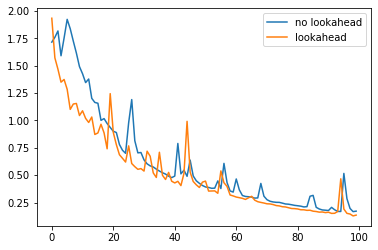

In [17]:
fig = plt.figure()
plt.plot(loss_list, label='no lookahead')
plt.plot(loss_list1, label='lookahead')
plt.legend()
plt.savefig('lookhead-cifar10-test.png', dpi=200)